# Familial Logistic Regression Models Using Merged Data Experiment 1.1

In [25]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import csv
import pickle
import warnings
import stanza

from random import shuffle
from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

# Initialize lemmatizer, stop words, and stanza
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline


2024-07-19 18:00:15 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-19 18:00:15 INFO: Downloading default packages for language: en (English) ...
2024-07-19 18:00:16 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-07-19 18:00:21 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-07-19 18:00:21 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-07-19 18:00:21 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-19 18:00:23 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-07-19 18:00:23 INFO: Using device: cpu
2024-07-19 18:00:23 INFO: Loading: tokenize
2024-07-19 18:00:23 INFO: Loading: mwt
2024-07-19 18:00:24 INFO: Loading: pos
2024-07-19 18:00:24 INFO: Loading: lemma
2024-07-19 18:00:24 INFO: Loading: constituency
2024-07-19 18:00:24 INFO: Loading: depparse
2024-07-19 18:00:25 INFO: Loading: sentiment
2024-07-19 18:00:25 INFO: Loading: 

## 1. Loading the data and quick exploratory data analysis

In [3]:
merged_familial_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Familial_sentence_level_batch_1_jaccard.csv", encoding='utf-8')

# Shuffle the merged dataset
merged_familial_df = shuffle(merged_familial_df, random_state=seed)

# Train-test split 
training_df, test_df = train_test_split(merged_familial_df, test_size=0.1, random_state=18, stratify=merged_familial_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [4]:
training_df.head()

,sentence,label,phrase
0,im not shy to say it how it is and it will drive me to success.,0,['That everything I do with my life will not only help my family but everyone in my community.']
1,"what's more, my dream is to become a veterinarian, but in china, there is only limited program that focus on veterinarian science.i transferred from university of california, santa barbara because san francisco is the city i want to stay for the rest of my life and i love everything about sf state.i am here because physics 122 is one of my major lower division class.",0,"['I am an International student from China, and my parents send me here because they want me to have better education resources.']"
2,i am here in united states because my father migrated us from philippines to have a better opportunity and to be able to have a degree that i can have and use my degree where ever i go.,0,['Having a degree will have more opportunity such as better job offers in order to support the family needs']
3,"a lot of what my family taught us throughout the years has always been through education and knowing that, thats what our biggest goal was.",1,"['A lot of what my family taught us throughout the years has always been through education and knowing that, thats what our biggest goal was.']"
4,this is why im here at san francisco state university majoring in biology concentration in physiology to in hopes one day become a pediatric nurse and to work as hard as i can so that one day i could return something back to my parents and make them proud for what theyve given up for me to live a better life.,1,['This is why Im here at San Francisco State University majoring in Biology concentration in Physiology to in hopes one day become a pediatric nurse and to work as hard as I can so that one day I could return something back to my parents and make them proud for what theyve given up for me to live a better life.']


In [5]:
test_df.head()

,sentence,label,phrase
0,"however, the decision to go to college was completely up to us.",0,"['My parents immigrated to U.S. in large part to provide their future kids with better opportunities and the financial stability required for us to go to college.', 'Im happy it makes my parents proud as well.']"
1,i am here for myself and for everyone that has supported me throughout my journey at san francisco state.,0,['I am here to make my familys sacrifices worth it.']
2,when asked the question of why i am here i think about my parents and their experience and message to me.,1,"['When asked the question of why I am here I think about my parents and their experience and message to me.', 'When I started high school my parents talked to me about the struggle with balancing our family along with school and work. My mom and dad cemented in me that the only way to avoid such a hectic beginning to life was to go to college right after high school']"
3,she always told me that you had to study more so you wont get the same path as she did in the past.,0,"['because of that I have to make a lot effort to finish my degree and get a good job after school and give them a well living life.', 'so its my time to finishing her dream and give her a better life in the future.']"
4,"im here in the astronomy 116 class because of all the general education lab choices, astronomy piqued my interest the most.",0,"['When I was younger, my sister introduced astrology to me, and I thought that Astronomy was the exact same thing.']"


In [6]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (1296, 3) 
Test dataset shape: (144, 3)
Positive labels present in the dataset : 141  out of 1296 or 10.87962962962963%
Positive labels present in the test dataset : 16  out of 144 or 11.11111111111111%


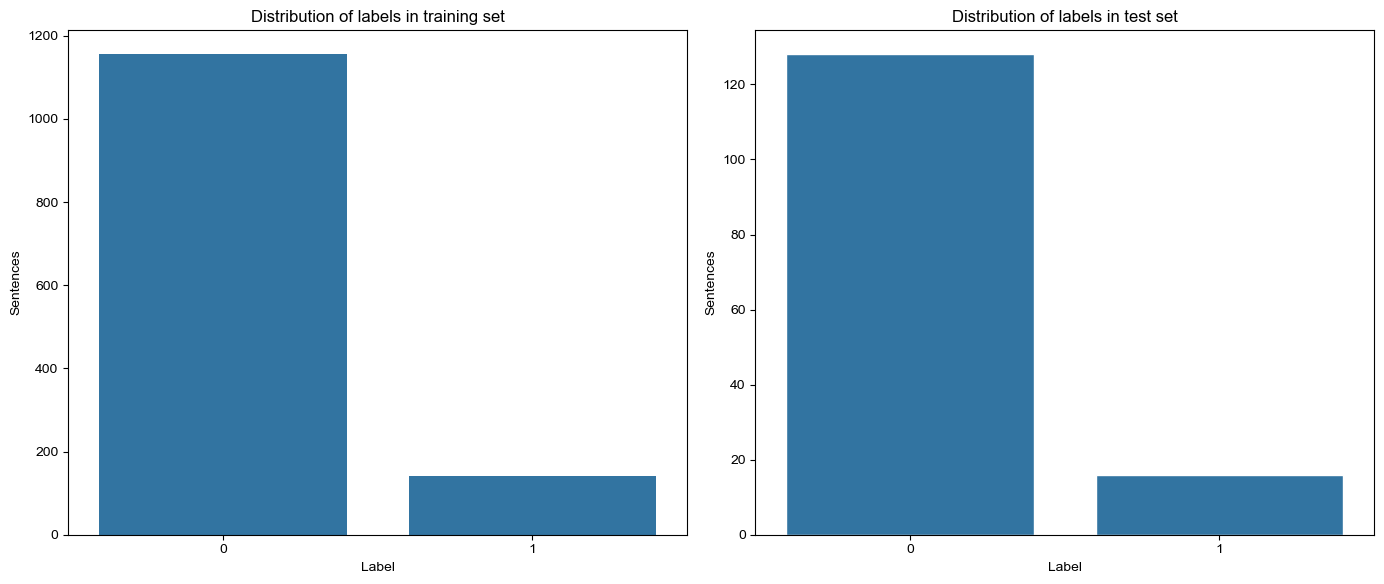

In [7]:
# Generate the data for the plots
training_counts = training_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the training set
sns.barplot(x=training_counts.index, y=training_counts.values, ax=axes[0])
axes[0].set_title('Distribution of labels in training set')
axes[0].set_ylabel('Sentences')
axes[0].set_xlabel('Label')
sns.set(style="whitegrid")

# Plot for the test set
sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1])
axes[1].set_title('Distribution of labels in test set')
axes[1].set_ylabel('Sentences')
axes[1].set_xlabel('Label')
sns.set(style="whitegrid")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## 2. Feature Engineering

### 1. NER

In [8]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [9]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

### 2. Similarity Features

In [10]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [11]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

### 3. Medical Word Count

In [12]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['abuse', 'care', 'pulmonary', 'glaucoma', 'genetic', 'male', 'rehabilitation', 'genetic', 'medical', 'ocular', 'nephrology', 'medicine', 'disease', 'clinical', 'electrophysiology', 'anesthesiology', 'adolescent', 'hospice', 'nuclear', 'endovascular', 'family', 'pediatric', 'cornea', 'ophthalmology', 'abdominal', 'radiology', 'interventional', 'procedural', 'forensic', 'endocrinology', 'surgical', 'behavioral', 'cardiothoracic', 'disabilities', 'obstetrics', 'liaison', 'pelvic', 'sports', 'neuroradiology', 'neurourology', 'research', 'interventional', 'sleep', 'geriatric', 'psychosomatic', 'preventive', 'public', 'gastrointestinal', 'community', 'ophthalmology', 'plastic', 'retina', 'adolescent', 'chest', 'infectious', 'rheumatology', 'fetal', 'urology', 'infectious', 'toxicology', 'renal', 'neonatal', 'female', 'dermatopathology', 'pain', 'hematology', 'transplant', 'cytopathology', 'neuromuscular', 'maternal', 'anesthesiology', 'sports', 'psychiatry', 'injury', 'banking', 'military',

In [13]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

### 4. Sentiment Polarity and Subjectivity

In [14]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

### 5. POS Tag Count

In [15]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [16]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 6. Word Embeddings

In [17]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [18]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [19]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [20]:
# Function to split text into words
def split_into_words(text):
    return text.split()

### 7. Unigrams

In [21]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

### 8. Putting them all together

In [22]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [34]:
X_train, y_train = feature_engineering(training_df)

In [35]:
X_train.shape

(1296, 121)

In [36]:
y_train = y_train.astype('int')

In [23]:
X_test, y_test = feature_engineering(test_df)

In [62]:
X_test.shape

(471, 121)

In [38]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [39]:
X_train.shape

(1296, 121)

In [40]:
X_test.shape

(144, 121)

In [24]:
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Familial/saved_features/X_test_final.csv", index=False)

In [1]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Familial/saved_features/X_train_final.csv", index=False)
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Familial/saved_features/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Familial/saved_features/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Familial/saved_features/y_test.csv", index=False)


NameError: name 'X_train' is not defined

In [42]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (1296, 1160)


In [43]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [44]:
X_train_final.columns = X_train_final.columns.astype(str)

In [45]:
X_train_final.shape

(1296, 1281)

In [46]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (144, 1160)


In [47]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(144, 1281)

In [48]:
X_test_final.columns = X_test_final.columns.astype(str)

In [49]:
X_test_final.shape

(144, 1281)

In [75]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [50]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:1281]]

In [51]:
X_train_model_1.shape

(1296, 1170)

In [53]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:1281]]

In [54]:
X_test_model_1.shape

(144, 1170)

In [55]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.514
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9550    0.8281    0.8870       128
           1     0.3333    0.6875    0.4490        16

    accuracy                         0.8125       144
   macro avg     0.6441    0.7578    0.6680       144
weighted avg     0.8859    0.8125    0.8384       144



In [56]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 106, False Positive: 22, False Negative: 5, True Positive: 11
--------------------------------------------------------------------------------
[[106  22]
 [  5  11]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       128
           1       0.33      0.69      0.45        16

    accuracy                           0.81       144
   macro avg       0.64      0.76      0.67       144
weighted avg       0.89      0.81      0.84       144



### Model 2: All Features

In [57]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:1281]]

In [59]:
X_train_model_2.shape

(1296, 1278)

In [60]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:1281]]

In [61]:
X_test_model_2.shape

(144, 1278)

In [63]:
model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.500
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9459    0.8203    0.8787       128
           1     0.3030    0.6250    0.4082        16

    accuracy                         0.7986       144
   macro avg     0.6245    0.7227    0.6434       144
weighted avg     0.8745    0.7986    0.8264       144



In [65]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 105, False Positive: 23, False Negative: 6, True Positive: 10
--------------------------------------------------------------------------------
[[105  23]
 [  6  10]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       128
           1       0.30      0.62      0.41        16

    accuracy                           0.80       144
   macro avg       0.62      0.72      0.64       144
weighted avg       0.87      0.80      0.83       144



### Model 3: Without Unigrams

In [67]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [68]:
X_train_model_3.shape

(1296, 118)

In [69]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [70]:
X_test_model_3.shape

(144, 118)

In [80]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.421
Best parameters set:
	clf__C: 25
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9450    0.8047    0.8692       128
           1     0.2857    0.6250    0.3922        16

    accuracy                         0.7847       144
   macro avg     0.6153    0.7148    0.6307       144
weighted avg     0.8717    0.7847    0.8162       144



In [72]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 103, False Positive: 25, False Negative: 6, True Positive: 10
--------------------------------------------------------------------------------
[[103  25]
 [  6  10]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       128
           1       0.29      0.62      0.39        16

    accuracy                           0.78       144
   macro avg       0.62      0.71      0.63       144
weighted avg       0.87      0.78      0.82       144



### Model 4: Without Embeddings

In [73]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:1281]]

In [74]:
X_train_model_4.shape

(1296, 1178)

In [75]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:1281]]

In [76]:
X_test_model_4.shape

(144, 1178)

In [81]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.512
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9550    0.8281    0.8870       128
           1     0.3333    0.6875    0.4490        16

    accuracy                         0.8125       144
   macro avg     0.6441    0.7578    0.6680       144
weighted avg     0.8859    0.8125    0.8384       144



In [82]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 106, False Positive: 22, False Negative: 5, True Positive: 11
--------------------------------------------------------------------------------
[[106  22]
 [  5  11]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       128
           1       0.33      0.69      0.45        16

    accuracy                           0.81       144
   macro avg       0.64      0.76      0.67       144
weighted avg       0.89      0.81      0.84       144



### Model 5: Without POS Tag Count

In [83]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:1281]]

In [84]:
X_train_model_5.shape

(1296, 1270)

In [85]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:1281]]

In [86]:
X_test_model_5.shape

(144, 1270)

In [87]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.499
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       128
           1       0.40      0.75      0.52        16

    accuracy                           0.85       144
   macro avg       0.68      0.80      0.72       144
weighted avg       0.90      0.85      0.87       144



In [88]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 110, False Positive: 18, False Negative: 4, True Positive: 12
--------------------------------------------------------------------------------
[[110  18]
 [  4  12]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       128
           1       0.40      0.75      0.52        16

    accuracy                           0.85       144
   macro avg       0.68      0.80      0.72       144
weighted avg       0.90      0.85      0.87       144



### Model 6: Without STEM Similarity

In [91]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:1281]]

In [92]:
X_train_model_6.shape

(1296, 1271)

In [93]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:1281]]

In [94]:
X_test_model_6.shape

(144, 1271)

In [95]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.511
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       128
           1       0.32      0.69      0.44        16

    accuracy                           0.81       144
   macro avg       0.64      0.75      0.66       144
weighted avg       0.88      0.81      0.83       144



In [96]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 105, False Positive: 23, False Negative: 5, True Positive: 11
--------------------------------------------------------------------------------
[[105  23]
 [  5  11]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       128
           1       0.32      0.69      0.44        16

    accuracy                           0.81       144
   macro avg       0.64      0.75      0.66       144
weighted avg       0.88      0.81      0.83       144



### Model 7: Without Sentiment Features

In [97]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:1281]]

In [98]:
X_train_model_7.shape

(1296, 1276)

In [99]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:1281]]

In [100]:
X_test_model_7.shape

(144, 1276)

In [101]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.505
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       128
           1       0.33      0.62      0.43        16

    accuracy                           0.82       144
   macro avg       0.64      0.73      0.66       144
weighted avg       0.88      0.82      0.84       144



In [102]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 108, False Positive: 20, False Negative: 6, True Positive: 10
--------------------------------------------------------------------------------
[[108  20]
 [  6  10]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       128
           1       0.33      0.62      0.43        16

    accuracy                           0.82       144
   macro avg       0.64      0.73      0.66       144
weighted avg       0.88      0.82      0.84       144



### Model 8: Without NER

In [103]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:1281]]

In [104]:
X_train_model_8.shape

(1296, 1277)

In [105]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:1281]]

In [106]:
X_test_model_8.shape

(144, 1277)

In [107]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.500
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       128
           1       0.30      0.62      0.41        16

    accuracy                           0.80       144
   macro avg       0.62      0.72      0.64       144
weighted avg       0.87      0.80      0.83       144



In [108]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 105, False Positive: 23, False Negative: 6, True Positive: 10
--------------------------------------------------------------------------------
[[105  23]
 [  6  10]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       128
           1       0.30      0.62      0.41        16

    accuracy                           0.80       144
   macro avg       0.62      0.72      0.64       144
weighted avg       0.87      0.80      0.83       144



### Final Summary
| Experiment | Model Number | Features Used                                                | Precision | Recall | Macro F1 | Ranking               |
| :--------: | :----------: | :----------------------------------------------------------: | :-------: | :----: | :------: | :-------------------: |
| Baseline   | 1            | Unigrams, POS Tag Count, Sentiment Polarity and Subjectivity | 0.64      | 0.76   | 0.67     |                       |
| Baseline   | 2            | All features (baseline)                                      | 0.62      | 0.72   | 0.64     |                       |
| Baseline   | 3            | Without Unigrams                                             | 0.62      | 0.71   | 0.63     |                       |
| Baseline   | 4            | Without Embeddings                                           | 0.64      | 0.76   | 0.67     |                       |
| Baseline   | 5            | **Without POS tag**                                          | 0.68      | 0.8    | 0.72     |      1                |
| Baseline   | 6            | Without STEM similarity (paper baseline)                     | 0.64      | 0.75   | 0.66     |                       |
| Baseline   | 7            | Without sentiment features                                   | 0.64      | 0.73   | 0.66     |                       |
| Baseline   | 8            | Without NER                                                  | 0.62      | 0.72   | 0.64     |                       |